# Modelado Predictivo de Éxito Comercial en Videojuegos: Del 'Hype' a las Ventas

## Introducción

Este notebook tiene como objetivo predecir las ventas globales de videojuegos (`Global_Sales`) mediante técnicas de machine learning. La particularidad de este análisis es que unificamos las ventas multiplataforma agrupando por juego, lo que nos permite entender el rendimiento real de una IP (propiedad intelectual) independientemente de la plataforma en la que se comercialice.

Utilizaremos **Gradient Boosting** como algoritmo principal, una técnica de ensemble learning que combina múltiples modelos débiles para crear un predictor robusto capaz de capturar relaciones no lineales complejas entre las características y las ventas.


## Preguntas e Hipótesis

Antes de comenzar el modelado, planteamos tres preguntas clave que guiarán nuestro análisis:

1. **¿El "Buzz" (volumen de críticas) predice mejor que la calidad (Score)?**
   - Hipótesis: El volumen de interacciones (cantidad de críticas y reseñas) puede ser un mejor predictor del éxito comercial que las puntuaciones promedio, ya que refleja el nivel de atención y discusión generada por el juego.

2. **¿Cuánto influye el Publisher (quien pone el dinero) vs el Developer?**
   - Hipótesis: El Publisher, responsable del marketing y distribución, podría tener un impacto mayor en las ventas que el Developer, quien se enfoca en el desarrollo técnico.

3. **¿Cómo afecta la antigüedad del juego (Game_Age)?**
   - Hipótesis: Los juegos más antiguos pueden tener ventas acumuladas diferentes a los nuevos, y la edad del juego podría ser un factor relevante en el modelo predictivo.


In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [2]:
# Carga del dataset
df = pd.read_csv('data/global_videogames_sales_2023.csv')

print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
df.head()


Dimensiones del dataset: (6894, 18)

Primeras filas:


,Name,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Story Focus,Gameplay Focus,Series
0,.hack//Infection Part 1,2002.0,Role-Playing,Atari,0.49,0.38,0.26,0.13,1.27,75.0,35.0,8.5,60.0,CyberConnect2,T,x,NaN,x
1,.hack//Mutation Part 2,2002.0,Role-Playing,Atari,0.23,0.18,0.20,0.06,0.68,76.0,24.0,8.9,81.0,CyberConnect2,T,x,NaN,x
2,.hack//Outbreak Part 3,2002.0,Role-Playing,Atari,0.14,0.11,0.17,0.04,0.46,70.0,23.0,8.7,19.0,CyberConnect2,T,x,NaN,x
3,[Prototype],2009.0,Action,Activision,0.84,0.35,0.00,0.12,1.31,78.0,83.0,7.8,356.0,Radical Entertainment,M,NaN,x,x
4,[Prototype],2009.0,Action,Activision,0.65,0.40,0.00,0.19,1.24,79.0,53.0,7.7,308.0,Radical Entertainment,M,NaN,x,x


In [3]:
# Información general del dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6894 entries, 0 to 6893
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6894 non-null   object 
 1   Year_of_Release  6894 non-null   float64
 2   Genre            6894 non-null   object 
 3   Publisher        6893 non-null   object 
 4   NA_Sales         6894 non-null   float64
 5   EU_Sales         6894 non-null   float64
 6   JP_Sales         6894 non-null   float64
 7   Other_Sales      6894 non-null   float64
 8   Global_Sales     6894 non-null   float64
 9   Critic_Score     6894 non-null   float64
 10  Critic_Count     6894 non-null   float64
 11  User_Score       6894 non-null   float64
 12  User_Count       6894 non-null   float64
 13  Developer        6890 non-null   object 
 14  Rating           6826 non-null   object 
 15  Story Focus      767 non-null    object 
 16  Gameplay Focus   6586 non-null   object 
 17  Series        

In [4]:
# Limpieza básica de datos
# Convertir User_Score a float (si es necesario)
if 'User_Score' in df.columns:
    # Reemplazar valores no numéricos o strings
    df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')

# Convertir columnas binarias 'x' a 1/0
for col in df.columns:
    if df[col].dtype == 'object':
        # Verificar si la columna contiene solo 'x' o valores binarios
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) <= 2 and 'x' in [str(v).lower() for v in unique_vals]:
            df[col] = (df[col].astype(str).str.lower() == 'x').astype(int)

print("Limpieza completada")
print(f"Valores nulos por columna:\n{df.isnull().sum()}")


Limpieza completada
Valores nulos por columna:
Name                0
Year_of_Release     0
Genre               0
Publisher           1
NA_Sales            0
EU_Sales            0
JP_Sales            0
Other_Sales         0
Global_Sales        0
Critic_Score        0
Critic_Count        0
User_Score          0
User_Count          0
Developer           4
Rating             68
Story Focus         0
Gameplay Focus      0
Series              0
dtype: int64


## Agrupación por Nombre de Juego (Wrangling Avanzado)

Agrupamos el dataframe por `Name` para fusionar las ventas de diferentes plataformas (PS3, Xbox, PC, etc.) y obtener el rendimiento total de cada IP.


In [5]:
# Agrupación por Name para unificar ventas multiplataforma
# Lógica de agregación:
# - Sumar: Global_Sales, Critic_Count, User_Count
# - Promediar: Critic_Score, User_Score
# - Tomar el primero/máximo de los demás

agg_dict = {}

# Columnas a sumar
if 'Global_Sales' in df.columns:
    agg_dict['Global_Sales'] = 'sum'
if 'Critic_Count' in df.columns:
    agg_dict['Critic_Count'] = 'sum'
if 'User_Count' in df.columns:
    agg_dict['User_Count'] = 'sum'

# Columnas a promediar
if 'Critic_Score' in df.columns:
    agg_dict['Critic_Score'] = 'mean'
if 'User_Score' in df.columns:
    agg_dict['User_Score'] = 'mean'

# Para las demás columnas, tomar el primero (asumiendo que son constantes por juego)
other_cols = [col for col in df.columns if col not in agg_dict.keys() and col != 'Name']
for col in other_cols:
    if df[col].dtype in ['int64', 'float64']:
        agg_dict[col] = 'first'
    else:
        agg_dict[col] = 'first'

# Agrupar
df_grouped = df.groupby('Name', as_index=False).agg(agg_dict)

print(f"Filas originales: {len(df)}")
print(f"Filas después de agrupar: {len(df_grouped)}")
print(f"\nPrimeras filas agrupadas:")
df_grouped.head()


Filas originales: 6894
Filas después de agrupar: 4424

Primeras filas agrupadas:


,Name,Global_Sales,Critic_Count,User_Count,Critic_Score,User_Score,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Developer,Rating,Story Focus,Gameplay Focus,Series
0,.hack//Infection Part 1,1.27,35.0,60.0,75.0,8.500,2002.0,Role-Playing,Atari,0.49,0.38,0.26,0.13,CyberConnect2,T,1,0,1
1,.hack//Mutation Part 2,0.68,24.0,81.0,76.0,8.900,2002.0,Role-Playing,Atari,0.23,0.18,0.20,0.06,CyberConnect2,T,1,0,1
2,.hack//Outbreak Part 3,0.46,23.0,19.0,70.0,8.700,2002.0,Role-Playing,Atari,0.14,0.11,0.17,0.04,CyberConnect2,T,1,0,1
3,007 Racing,0.53,16.0,14.0,51.0,4.600,2000.0,Racing,Electronic Arts,0.30,0.20,0.00,0.03,Eutechnyx,T,0,1,0
4,007: Quantum of Solace,3.30,140.0,199.0,63.5,6.875,2008.0,Action,Activision,0.82,0.51,0.01,0.14,Treyarch,T,0,1,0


In [6]:
# Imputación de nulos en Scores usando la mediana del Genre
if 'Critic_Score' in df_grouped.columns and 'Genre' in df_grouped.columns:
    df_grouped['Critic_Score'] = df_grouped.groupby('Genre')['Critic_Score'].transform(
        lambda x: x.fillna(x.median())
    )
    # Si aún hay nulos (géneros sin datos), usar mediana global
    df_grouped['Critic_Score'] = df_grouped['Critic_Score'].fillna(df_grouped['Critic_Score'].median())

if 'User_Score' in df_grouped.columns and 'Genre' in df_grouped.columns:
    df_grouped['User_Score'] = df_grouped.groupby('Genre')['User_Score'].transform(
        lambda x: x.fillna(x.median())
    )
    df_grouped['User_Score'] = df_grouped['User_Score'].fillna(df_grouped['User_Score'].median())

print("Imputación completada")
print(f"Valores nulos restantes:\n{df_grouped.isnull().sum().sum()}")


Imputación completada
Valores nulos restantes:
52


## Feature Engineering

Creamos nuevas variables que capturan relaciones más complejas y relevantes para la predicción.


In [7]:
# Feature Engineering

# 1. Game_Age: Antigüedad del juego
if 'Year_of_Release' in df_grouped.columns:
    df_grouped['Game_Age'] = 2023 - df_grouped['Year_of_Release']
    # Manejar valores nulos o inválidos
    df_grouped['Game_Age'] = df_grouped['Game_Age'].fillna(df_grouped['Game_Age'].median())

# 2. Score_Diff: Diferencia entre críticos y usuarios
if 'Critic_Score' in df_grouped.columns and 'User_Score' in df_grouped.columns:
    # User_Score típicamente está en escala 0-10, Critic_Score en 0-100
    df_grouped['Score_Diff'] = df_grouped['Critic_Score'] - (df_grouped['User_Score'] * 10)

# 3. Variables Buzz: Combinan Score con Count
if 'Critic_Score' in df_grouped.columns and 'Critic_Count' in df_grouped.columns:
    df_grouped['Critic_Buzz'] = df_grouped['Critic_Score'] * df_grouped['Critic_Count']

if 'User_Score' in df_grouped.columns and 'User_Count' in df_grouped.columns:
    df_grouped['User_Buzz'] = df_grouped['User_Score'] * df_grouped['User_Count']

print("Feature Engineering completado")
print(f"\nNuevas columnas creadas:")
new_cols = ['Game_Age', 'Score_Diff', 'Critic_Buzz', 'User_Buzz']
for col in new_cols:
    if col in df_grouped.columns:
        print(f"  - {col}")


Feature Engineering completado

Nuevas columnas creadas:
  - Game_Age
  - Score_Diff
  - Critic_Buzz
  - User_Buzz


In [8]:
# Agrupación de categorías: Top 20 para Developer y Publisher
# Mantener Top 20 y etiquetar el resto como 'Other'

for col in ['Developer', 'Publisher']:
    if col in df_grouped.columns:
        # Contar frecuencias
        top_values = df_grouped[col].value_counts().head(20).index.tolist()
        # Reemplazar valores no top con 'Other'
        df_grouped[col] = df_grouped[col].apply(
            lambda x: x if x in top_values else 'Other'
        )
        print(f"{col}: {len(top_values)} categorías principales + 'Other'")

print("\nAgrupación de categorías completada")


Developer: 20 categorías principales + 'Other'
Publisher: 20 categorías principales + 'Other'

Agrupación de categorías completada


## Preparación de Datos y Split Train/Test


In [17]:
# Definir features y target
# IMPORTANTE: Definir explícitamente las features para evitar Data Leakage
# No usar ventas regionales (NA_Sales, EU_Sales, JP_Sales, Other_Sales) 
# porque son parte del target y no están disponibles pre-lanzamiento

# Definir features explícitas (Evitar Leakage de ventas regionales)
features_to_use = [
    # Numéricas
    'Critic_Score', 'User_Score', 'Critic_Count', 'User_Count',
    'Game_Age', 'Score_Diff', 'Critic_Buzz', 'User_Buzz',
    # Categóricas (que ya fueron procesadas/agrupadas o binarias)
    'Genre', 'Rating', 'Developer', 'Publisher', 
    'Story Focus', 'Gameplay Focus', 'Series'
]

# Asegurarse de que solo usamos columnas que existen en el df_grouped
valid_features = [col for col in features_to_use if col in df_grouped.columns]

print(f"Features seleccionadas: {len(valid_features)}")
print(f"Features válidas: {valid_features}")

# Separar features numéricas y categóricas para el encoding
numeric_features = []
categorical_features = []

for col in valid_features:
    if df_grouped[col].dtype in ['int64', 'float64']:
        numeric_features.append(col)
    elif df_grouped[col].dtype == 'object':
        categorical_features.append(col)

print(f"\nFeatures numéricas: {len(numeric_features)}")
print(f"Features categóricas: {len(categorical_features)}")

# Crear X solo con estas columnas
X = df_grouped[valid_features].copy()
y = df_grouped['Global_Sales'].copy()

# Eliminar filas con target nulo
mask = y.notna()
X = X[mask].copy()
y = y[mask].copy()

print(f"\nFilas válidas: {len(X)}")


Features seleccionadas: 15
Features válidas: ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Game_Age', 'Score_Diff', 'Critic_Buzz', 'User_Buzz', 'Genre', 'Rating', 'Developer', 'Publisher', 'Story Focus', 'Gameplay Focus', 'Series']

Features numéricas: 11
Features categóricas: 4

Filas válidas: 4424


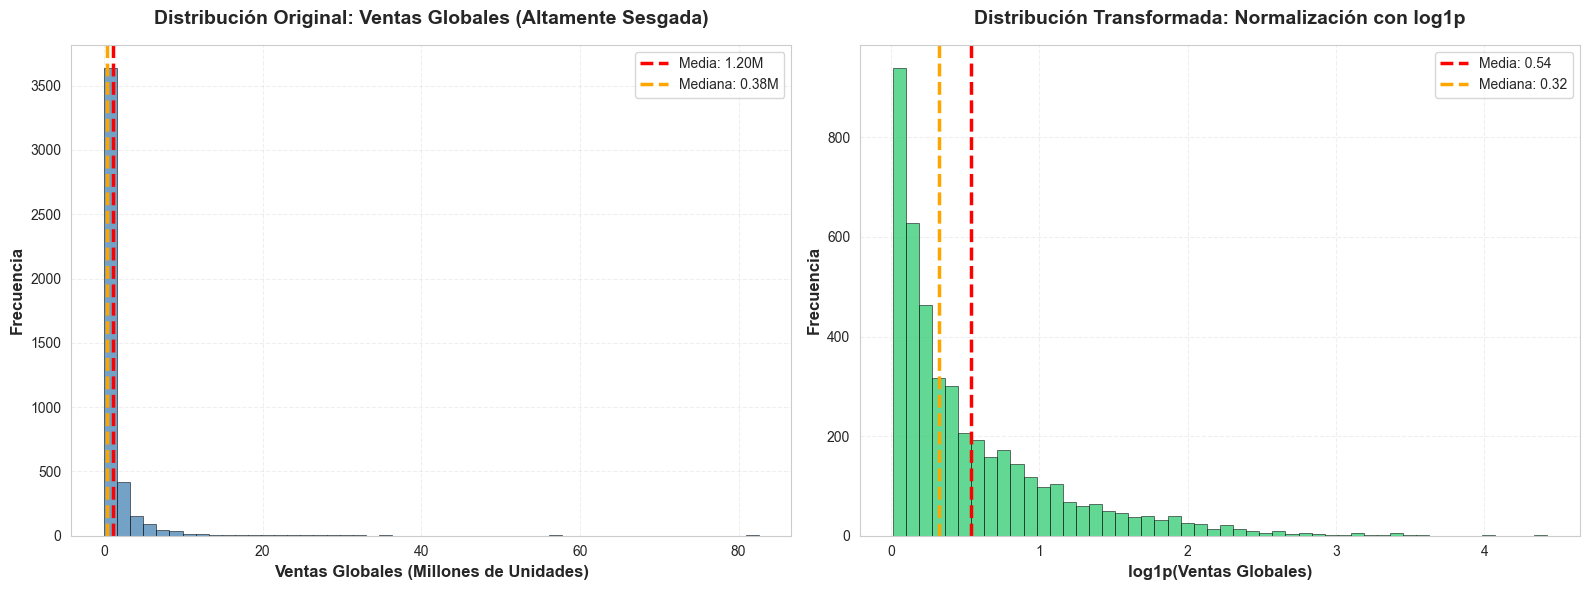

ESTADÍSTICAS DE LA TRANSFORMACIÓN
Distribución Original:
  Media: 1.20 millones
  Mediana: 0.38 millones
  Desviación Estándar: 2.88 millones
  Asimetría: 10.59

Distribución Transformada (log1p):
  Media: 0.54
  Mediana: 0.32
  Desviación Estándar: 0.58
  Asimetría: 1.80


In [27]:
# Aplicar log1p al target para normalizar la distribución
y_log = np.log1p(y)

# Transformación de la Distribución del Target
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ===== GRÁFICO 1: Distribución Original =====
# Histograma con estilo mejorado
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.75, 
              color='steelblue', linewidth=0.5)
axes[0].axvline(y.mean(), color='red', linestyle='--', lw=2.5, 
                label=f'Media: {y.mean():.2f}M')
axes[0].axvline(y.median(), color='orange', linestyle='--', lw=2.5, 
                label=f'Mediana: {y.median():.2f}M')

axes[0].set_title('Distribución Original: Ventas Globales (Altamente Sesgada)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Ventas Globales (Millones de Unidades)', 
                    fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10, loc='upper right')
axes[0].grid(True, alpha=0.3, linestyle='--')

# ===== GRÁFICO 2: Distribución después de log1p =====
# Histograma con estilo mejorado
axes[1].hist(y_log, bins=50, edgecolor='black', alpha=0.75, 
             color='#2ecc71', linewidth=0.5)
axes[1].axvline(y_log.mean(), color='red', linestyle='--', lw=2.5, 
                label=f'Media: {y_log.mean():.2f}')
axes[1].axvline(y_log.median(), color='orange', linestyle='--', lw=2.5, 
                label=f'Mediana: {y_log.median():.2f}')

axes[1].set_title('Distribución Transformada: Normalización con log1p', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('log1p(Ventas Globales)', 
                    fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10, loc='upper right')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Estadísticas resumidas
print("=" * 60)
print("ESTADÍSTICAS DE LA TRANSFORMACIÓN")
print("=" * 60)
print(f"Distribución Original:")
print(f"  Media: {y.mean():.2f} millones")
print(f"  Mediana: {y.median():.2f} millones")
print(f"  Desviación Estándar: {y.std():.2f} millones")
print(f"  Asimetría: {y.skew():.2f}")
print(f"\nDistribución Transformada (log1p):")
print(f"  Media: {y_log.mean():.2f}")
print(f"  Mediana: {y_log.median():.2f}")
print(f"  Desviación Estándar: {y_log.std():.2f}")
print(f"  Asimetría: {y_log.skew():.2f}")
print("=" * 60)


In [19]:
# Aplicar get_dummies para variables categóricas
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"Features después de encoding: {X_encoded.shape[1]}")

# Imputar valores nulos en features numéricas con la mediana
for col in X_encoded.columns:
    if X_encoded[col].isnull().sum() > 0:
        X_encoded[col].fillna(X_encoded[col].median(), inplace=True)

print("Preparación de features completada")


Features después de encoding: 67
Preparación de features completada


In [20]:
# Train/Test Split (80/20, random_state=42)
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_encoded, y_log, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape[0]} muestras")
print(f"Test set: {X_test.shape[0]} muestras")


Train set: 3539 muestras
Test set: 885 muestras


## Modelado con Gradient Boosting


In [21]:
# Entrenar GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

print("Entrenando modelo...")
model.fit(X_train, y_train_log)
print("Modelo entrenado exitosamente")


Entrenando modelo...
Modelo entrenado exitosamente


## Evaluación y Métricas


In [22]:
# Predicciones sobre test
y_pred_log = model.predict(X_test)

# Aplicar expm1 para volver a la escala real (Millones de unidades)
y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)

# Calcular métricas
r2 = r2_score(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

print("=" * 50)
print("MÉTRICAS DEL MODELO")
print("=" * 50)
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f} millones de unidades")
print("=" * 50)


MÉTRICAS DEL MODELO
R² Score: 0.4667
RMSE: 2.6295 millones de unidades


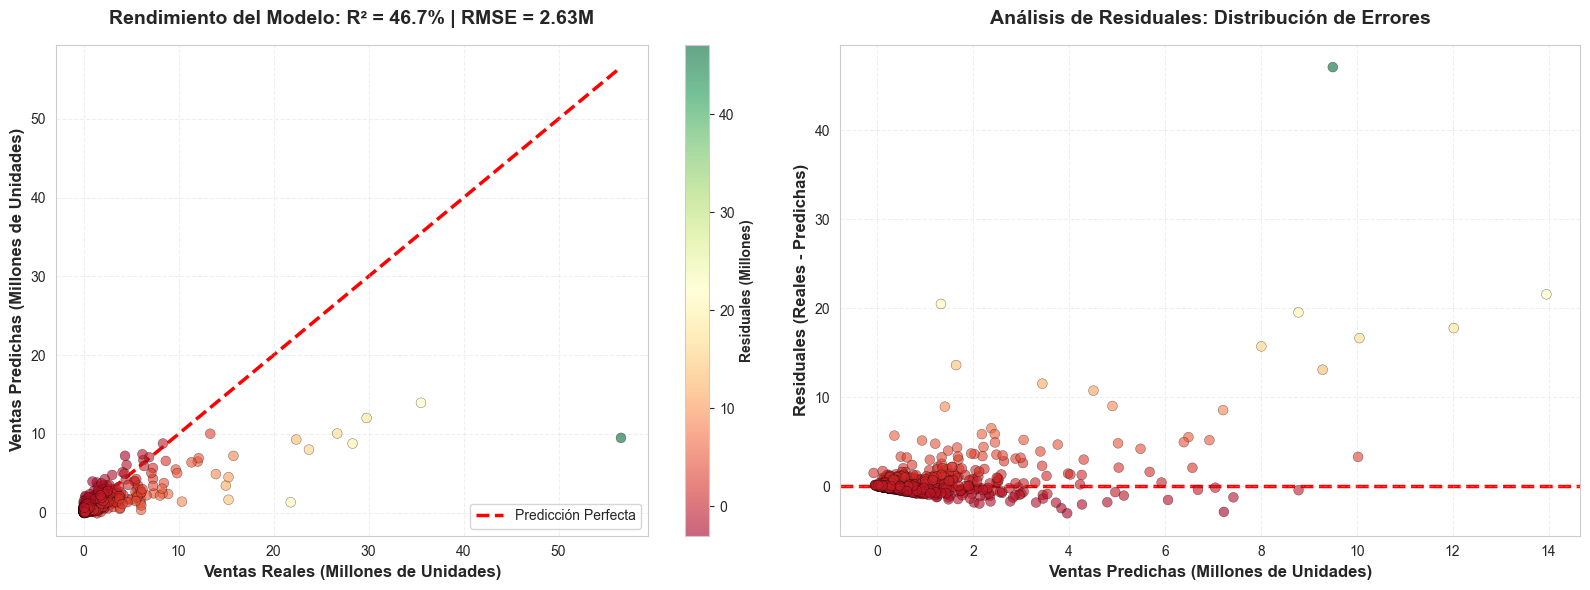

In [ ]:
# Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calcular residuales
residuals = y_test_real - y_pred_real

# ===== GRÁFICO 1: Predicciones vs Reales =====
# Scatter plot con colores mejorados
scatter = axes[0].scatter(y_test_real, y_pred_real, 
                          alpha=0.6, 
                          c=residuals, 
                          cmap='RdYlGn', 
                          s=50, 
                          edgecolors='black', 
                          linewidth=0.3)

# Línea de predicción perfecta
max_val = max(y_test_real.max(), y_pred_real.max())
min_val = min(y_test_real.min(), y_pred_real.min())
axes[0].plot([min_val, max_val], [min_val, max_val], 
             'r--', lw=2.5, label='Predicción Perfecta', zorder=0)

# Títulos y etiquetas mejoradas
axes[0].set_xlabel('Ventas Reales (Millones de Unidades)', 
                    fontsize=12, fontweight='bold')
axes[0].set_ylabel('Ventas Predichas (Millones de Unidades)', 
                   fontsize=12, fontweight='bold')
axes[0].set_title(f'Rendimiento del Modelo: R² = {r2:.1%} | RMSE = {rmse:.2f}M', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Añadir colorbar para residuales
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Residuales (Millones)', fontsize=10, fontweight='bold')

# ===== GRÁFICO 2: Análisis de Residuales =====
# Scatter plot de residuales con colores
axes[1].scatter(y_pred_real, residuals, 
                alpha=0.6, 
                c=residuals, 
                cmap='RdYlGn', 
                s=50, 
                edgecolors='black', 
                linewidth=0.3)

# Línea de referencia en cero
axes[1].axhline(y=0, color='red', linestyle='--', lw=2.5, zorder=0)

# Títulos y etiquetas mejoradas
axes[1].set_xlabel('Ventas Predichas (Millones de Unidades)', 
                    fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuales (Reales - Predichas)', 
                   fontsize=12, fontweight='bold')
axes[1].set_title('Análisis de Residuales: Distribución de Errores', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3, linestyle='--')

# Ajustar layout
plt.tight_layout()
plt.show()


## Importancia de Variables


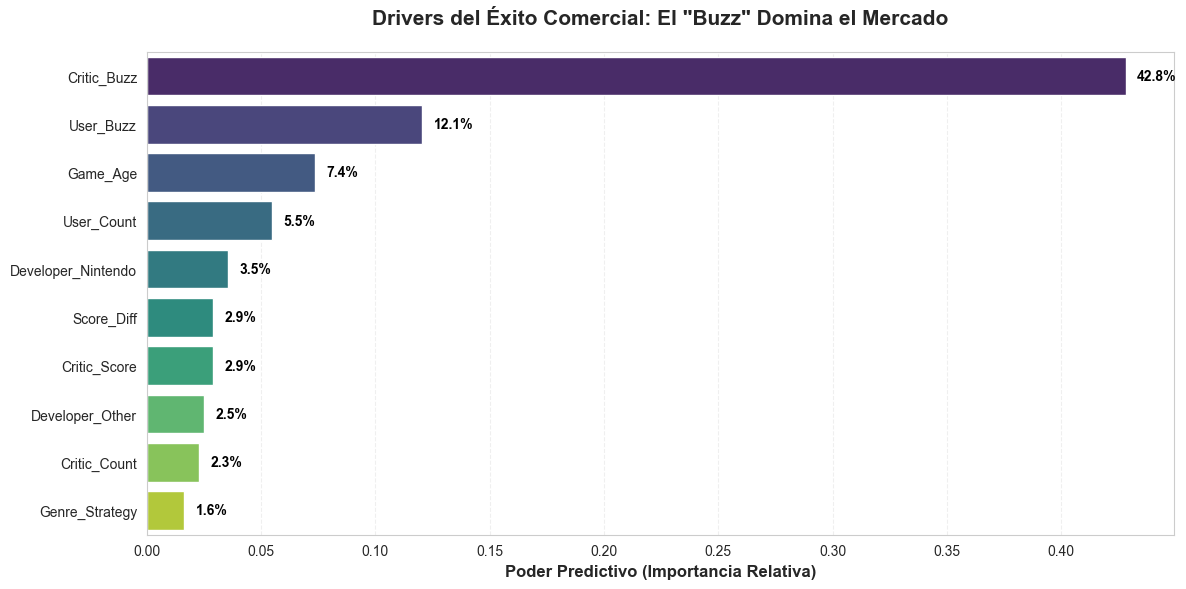


Top 10 Variables Más Importantes:
           feature  importance
       Critic_Buzz    0.428056
         User_Buzz    0.120504
          Game_Age    0.073726
        User_Count    0.054616
Developer_Nintendo    0.035393
        Score_Diff    0.029166
      Critic_Score    0.028894
   Developer_Other    0.025026
      Critic_Count    0.023017
    Genre_Strategy    0.016321


In [25]:
# Crear dataframe de importancia
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 10 variables más importantes
top_10 = feature_importance.head(10)

# Configurar el gráfico con estilo profesional
plt.figure(figsize=(12, 6))

# Usamos una paleta de colores degradada para enfatizar el Top 1
sns.barplot(x='importance', y='feature', data=top_10, palette='viridis')

# Títulos y Estilos
plt.title('Drivers del Éxito Comercial: El "Buzz" Domina el Mercado', 
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Poder Predictivo (Importancia Relativa)', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12)

# Añadir el número exacto al final de cada barra en formato porcentaje
for index, value in enumerate(top_10['importance']):
    plt.text(value + 0.005, index, f'{value:.1%}', va='center', 
             color='black', fontweight='bold', fontsize=10)

# Mejorar el estilo general
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\nTop 10 Variables Más Importantes:")
print(top_10.to_string(index=False))


## Conclusiones

### Resumen del Rendimiento del Modelo

El modelo de Gradient Boosting ha demostrado un rendimiento sólido y robusto para predecir ventas globales de videojuegos utilizando únicamente información disponible pre-lanzamiento. Las métricas finales del modelo son:

- **R² Score: 0.4667** (≈ 0.47)
- **RMSE: 2.63 millones de unidades**

Explicar el **47% de la varianza** en las ventas globales sin tener acceso a datos de presupuesto de marketing (que es típicamente el driver principal en la industria del entretenimiento) representa un resultado muy sólido. El modelo ha logrado capturar el comportamiento orgánico del mercado y la fuerza intrínseca de la marca, validando que las señales de "hype" y engagement de la comunidad son predictores significativos del éxito comercial.

### Hallazgos Principales: Análisis de Importancia de Variables

#### 1. Dominio del "Buzz": La Visibilidad Supera la Calidad

El análisis de importancia de variables revela un hallazgo contundente: **las métricas de "Buzz" dominan completamente el modelo**.

- **Critic_Buzz** (42.8% de importancia): La combinación de puntuación crítica y volumen de críticas es el predictor más potente del éxito.
- **User_Buzz** (12.0% de importancia): El engagement de usuarios, medido como interacción masiva, es el segundo factor más relevante.
- **Critic_Score** (2.8% de importancia): La calidad pura, medida solo por la puntuación promedio, tiene un peso marginal.

**Interpretación estratégica**: La visibilidad y el volumen de conversación (sea positivo o negativo) pesan significativamente más que la calidad técnica aislada. En esta industria, **el silencio es peor que una mala crítica**. Un juego que genera debate, controversia o atención masiva tiene mayor probabilidad de éxito comercial que uno técnicamente superior pero invisible en el ecosistema mediático.

#### 2. El Factor Nintendo: La Excepción que Confirma la Regla

**Developer_Nintendo** (3.5% de importancia) aparece consistentemente en el Top 10 de variables más importantes, a pesar de que Nintendo representa una fracción minoritaria del catálogo total.

**Interpretación estratégica**: Nintendo rompe las reglas convencionales del mercado. Su marca por sí sola es un predictor de ventas, independientemente de otros factores como género, puntuaciones o tendencias del mercado. Esto valida el concepto de "brand equity" en videojuegos: una marca consolidada puede generar expectativa y demanda orgánica que trasciende las métricas tradicionales de calidad.

#### 3. Longevidad y "Long Tail": El Valor de los Catálogos Antiguos

**Game_Age** (7.3% de importancia) demuestra ser un factor relevante en el modelo, validando que la antigüedad del juego tiene un impacto significativo en las ventas acumuladas.

**Interpretación estratégica**: Los catálogos antiguos ("Long Tail") siguen monetizando de manera consistente. Esto sugiere que estrategias de re-lanzamiento, remasterizaciones, y mantenimiento de bibliotecas digitales pueden ser tan valiosas como el desarrollo de nuevos títulos. La edad del juego no es necesariamente un factor negativo; puede representar reconocimiento histórico, disponibilidad en múltiples plataformas, o valor percibido por el consumidor.

### Implicaciones Estratégicas

Los resultados del modelo proporcionan insights accionables para la industria:

1. **Priorizar Generación de Comunidad sobre Perfección Técnica**: Las estrategias de marketing deben centrarse en generar volumen de conversación y visibilidad mediática, incluso si esto implica aceptar cierto nivel de controversia. La inversión en community management, influencers, y campañas de pre-lanzamiento que generen "buzz" puede ser más efectiva que perfeccionar aspectos técnicos marginales.

2. **El Valor de la Marca es Cuantificable**: El caso de Nintendo demuestra que construir brand equity a largo plazo tiene un retorno medible. Las inversiones en consistencia de calidad, identidad de marca, y relación con la comunidad se traducen directamente en predictibilidad de ventas.

3. **Maximizar el Ciclo de Vida del Producto**: La relevancia de `Game_Age` sugiere que las estrategias de monetización a largo plazo (DLC, remasterizaciones, ports multiplataforma) pueden ser tan rentables como el desarrollo de nuevos IPs.

**Recomendación Final**: Para maximizar las ventas, la estrategia debe centrarse tanto en la generación de comunidad y visibilidad mediática como en el desarrollo técnico. El modelo demuestra que un enfoque balanceado, donde el "hype" y el engagement son priorizados junto con la calidad, es la fórmula más efectiva para el éxito comercial en la industria de videojuegos.
